## This Notebook contains the code to Forecast the weekly sales at a Store Level for all 45 stores, by training Back Propagation Through Time (BPTT) models.
The approaches used & experiments carried out (seperate models for each store & single model) have been discussed below

In [1]:
from __future__ import print_function
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#### Reading Store level data

In [2]:
store_lvl_df = pd.read_csv('sales_forecasting_store_level.csv')

#### Here, Weekly_sales_sum is the target variable that captures the weekly sales of every store.

In [3]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0


#### Creating a periodic week_nbr column to capture week of the year value between 1 & 52. This column can capture the seasonality by holding the week of the year value

In [4]:
a = []
for el in store_lvl_df.week_nbr:
    if el>52 and el<=104:
        a.append(el-52)
    elif el>104:
        a.append(el-104)
    else:
        a.append(el)
week_nbr_periodic = pd.Series(a)
cols = list(store_lvl_df.columns)
cols.append('week_nbr_periodic')
store_lvl_df = pd.concat([store_lvl_df, week_nbr_periodic], axis = 1)
store_lvl_df.columns = cols

In [5]:
### Vary from Weeks 1 to 52 & repeat
print(store_lvl_df.columns)
print(store_lvl_df.week_nbr_periodic.unique())

Index(['Weekly_Sales_sum', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'week_nbr', 'Size', 'Type_A', 'Type_B',
       'Type_C', 'week_nbr_periodic'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [6]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


## APPROACH EXPERIMENT 1: Train 45 BPTT Models for each of the 45 stores using 'n' lagged Moving Window sequences
#### (Treating as Time Series data by using the previous 'n' week values as inputs)
We are going to train a seperate BPTT model for every store by using a window of 5 previous week inputs (sequence length 5) for all input attributes. We are experimenting with this approach of training a seperate model for each store to compare it against the performance of training a single model.

### 1. A. Training BPTT Model for each store on Train Data using all the input attributes and sequence length 5
#### Creating a dictionary of 90 tensor objects (Train & Test loader objects) for the 45 stores & also a Dictionary of Dataframes for Visualization purposes
We are using moving window with sequence length 5, such that 5 previous week's output variable values and also the predictor variable values will be used as input. Basically, every single attribute will use a sequence of 5 previous values to make predictions.
Creating a Tensor Object using the DataLoader function and specifying the batch size to perform mini-batch gradient descent. The algorithm will update weights after each batch. Here the train_loader dataset has the predictor variables and the target variable in it.

This data_prep function is being used to create a 3 dimensional numpy array where the 3 dimensions are [batch_size(no of observations in data) x sequence length of each attribute x number of attributes]. 

We are experimenting with different sequence lengths in approaches 1A & 1B.

In [7]:
### FUNCTION TO CREATE 'X' & 'Y' ARRAYs of the required sequence length. 
### x_arr will be a 3D Numpy object
def data_prep(xdata_arr,ydata_arr, input_seq_len):
    x_arr = []
    y_arr = []
    for i in range(len(xdata_arr)-input_seq_len):
        x_arr.append(xdata_arr[i:i+input_seq_len])
        y_arr.append(ydata_arr[i+input_seq_len])
    return np.array(x_arr), np.array(y_arr)

In [8]:
%%capture
stores_dict_tgt = {}
stores_dict_df = {}
stores_dict = {}   ### Creating a dictionary containing the 45 stores
no_lags = 5  ### Moving Window approach - number of lagged previous sales values

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
     
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Storing Dataframes into Dictionary
    stores_dict_df["store_{}_train".format(i)] = store_train
    stores_dict_df["store_{}_test".format(i)] = store_test
    
    ### Dropping unnecessary columns and creating X_Train, Y_Train, X_Test & Y_Test objects
    store_train_x = store_train.drop(columns=['Date','Store','week_nbr'])
    store_train_y = store_train['Weekly_Sales_sum'].to_frame()
    store_test_x = store_test.drop(columns=['Date','Store','week_nbr'])
    store_test_y = store_test['Weekly_Sales_sum'].to_frame()
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train_x)
    train_arr_x = scaler.transform(store_train_x)
    test_arr_x = scaler.transform(store_test_x)
    
    scaler = scaler.fit(store_train_y)
    train_arr_y = scaler.transform(store_train_y)
    test_arr_y = scaler.transform(store_test_y)
    
    ### Calling Data Prep Function to create multivariate sequences (5 lag moving window) Processed
    x_train, y_train = data_prep(train_arr_x,train_arr_y,5)
    x_test, y_test = data_prep(test_arr_x,test_arr_y,5)
    
    stores_dict_tgt["store_{}_train".format(i)] = [el[0] for el in y_train]
    stores_dict_tgt["store_{}_test".format(i)] = [el[0] for el in y_test]
    
    ### Creating Train & Test Loader Objects using the 3D 'x_train' numpy array & the '2D y_train' numpy arrays created
    train_target = torch.tensor(y_train.astype(np.float32))
    train = torch.tensor(x_train.astype(np.float32)) 
    train_tensor = torch.utils.data.TensorDataset(train, train_target) 
    train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = False)
    
    test_target = torch.tensor(y_test.astype(np.float32))
    test = torch.tensor(x_test.astype(np.float32)) 
    test_tensor = torch.utils.data.TensorDataset(test, test_target) 
    test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(test),shuffle = False)
    
    ### APPENDING Store's Train & Test LOADERs to dictionary
    stores_dict["store_{}_train".format(i)] = train_loader
    stores_dict["store_{}_test".format(i)] = test_loader

In [9]:
print(len(stores_dict))
print(stores_dict['store_1_train'].batch_size)

90
95


*The train object has 95 rows per batch, 11 attributes and sequence length of 5 for each attribute*

In [10]:
print(train.shape)
print(train_target.shape)
print(test.shape)
print(test_target.shape)

torch.Size([95, 5, 11])
torch.Size([95, 1])
torch.Size([38, 5, 11])
torch.Size([38, 1])


#### RNN Network
Using a RNN layer and one hidden state with dimensions of number of layers, batch size and number of nodes (hidden dim)

In [52]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers,seq_len):
        super(RNN_Model, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim,num_layers = n_layers, batch_first=True, nonlinearity='tanh')   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    
    #def reset_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    #    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.rnn(x, hidden)
        
        out_final = self.fc(out[:,-1,:])
        return out_final
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [53]:
### FUNCTION to calculate TEST MSE after every epoch
def test_mse_rnn(model,test_loader):
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs,targets in test_loader:
            output = model(inputs)
            loss = criterion(output, targets)
    return loss.item()

#### Plotting the MSE after every epoch to identify the optimum number of epochs required for convergence

In [54]:
input_size = 11
hidden_dim = 10
n_layers = 1
seq_len = 5
model_rnn = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
model_rnn = model_rnn.float()

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_rnn.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 300
train_MSE_aft_weight_upd_rnn = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd_rnn = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    #model_rnn.reset_hidden()
    for inputs,targets in stores_dict['store_1_train']:   
           # Training pass
        output = model_rnn(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_rnn.append(loss.item())        
        test_MSE_aft_weight_upd_rnn.append(test_mse_rnn(model_rnn,stores_dict['store_1_test']))

In [55]:
test_MSE_aft_weight_upd_rnn[-1]

0.00864119827747345

#### Identified 100 epochs as the optimum number of epochs for the LSTM model to converge

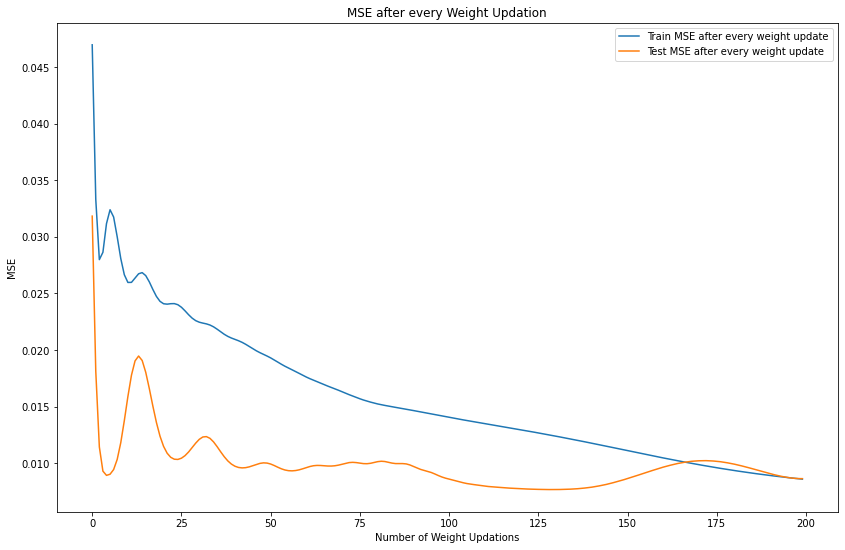

In [56]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_rnn)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_rnn)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

#### TRAINING 45 BPTT models for each of the 45 stores and making the sales predictions

In [66]:
input_size = 11
hidden_dim = 10
n_layers = 1
seq_len = 5

mse_train = []
mse_test = []
Y_pred_train_lst = []
Y_pred_test_lst = []

for i in range(1,int(len(stores_dict)/2)+1):
    train_loader = stores_dict["store_{}_train".format(i)]
    test_loader = stores_dict["store_{}_test".format(i)]

    model_rnn = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
    model_rnn = model_rnn.float()
    
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    
    optimizer = optim.Adam(model_rnn.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate
    
    epochs = 100


    ### Training on the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader:    
               # Training pass
            output = model_rnn(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
            
    with torch.no_grad():
        for inputs_train,targets_train in train_loader:
            Y_pred_train = model_rnn(inputs_train.float())  ### Week level Predicted Sales for each store's train data
            mse_train.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
            
    with torch.no_grad():    
        for inputs_test,targets_test in test_loader:
            Y_pred_test = model_rnn(inputs_test.float())  ### Weekly Predicted Sales for each store's test data
            mse_test.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data
    
    ### Append Weekly Predictions of each store into a list
    Y_pred_train_lst.append([el[0] for el in Y_pred_train.tolist()])
    Y_pred_test_lst.append([el[0] for el in Y_pred_test.tolist()])

#### Average Train & Test MSE across all 45 stores

In [67]:
print(float(sum(mse_test)/len(mse_test)))
print(float(sum(mse_train)/len(mse_train)))

0.02284127287566662
0.017092138528823853


#### Plotting Actual Vs Predicted Sales using Approach 1A, on Train & Test Data of Stores 20 & 4

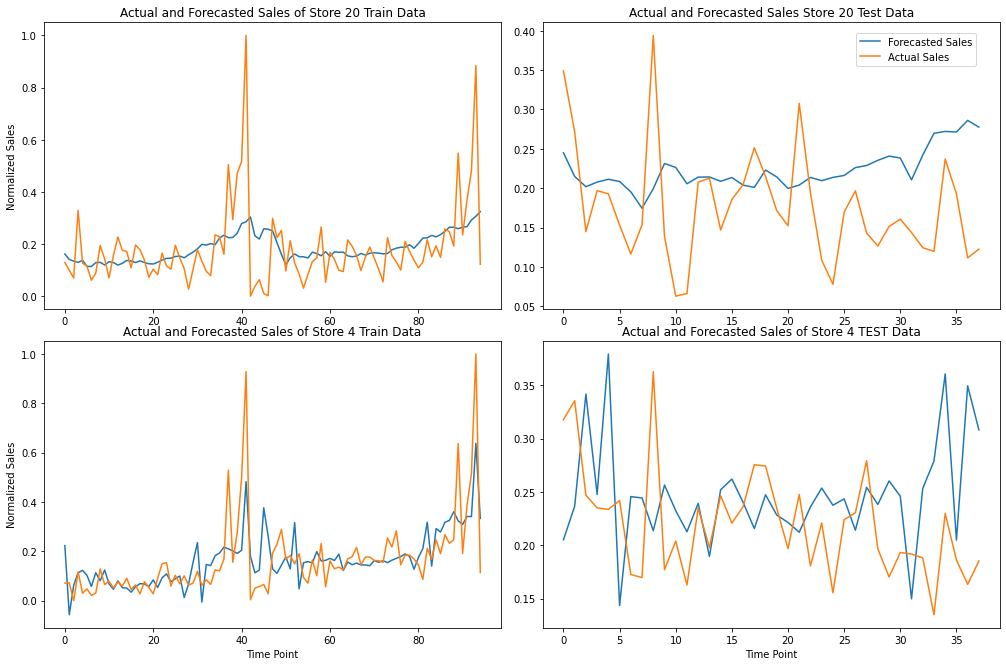

In [68]:
time_point_train = [el for el in range(0,95)]
time_point_test = [el for el in range(0,38)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst[19])
axs[0, 0].plot(time_point_train, list(stores_dict_tgt["store_20_train"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict_tgt["store_20_test"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst[3])
axs[1, 0].plot(time_point_train, list(stores_dict_tgt["store_4_train"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst[3])
axs[1, 1].plot(time_point_test, list(stores_dict_tgt["store_4_test"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

### 1. B. Training BPTT Model for each store on Train Data using a longer moving window of sequence length 10
#### Creating a dictionary of 90 tensor objects (Train & Test loader objects) for the 45 stores & also a Dictionary of Target variable lists for Visualization purposes
Creating a Tensor Object using the DataLoader function and specifying the batch size to perform mini-batch gradient descent. The algorithm will update weights after each batch. Here the train_loader dataset has the predictor variables and the target variable in it.
The train object has 3 dimensions of [batch_size x seq length x number of attributes]. Here we are using a sequence of length 10 for each attribute.

In [69]:
### FUNCTION TO CREATE 'X' & 'Y' ARRAYs 
def data_prep(xdata_arr,ydata_arr, input_seq_len):
    x_arr = []
    y_arr = []
    for i in range(len(xdata_arr)-input_seq_len):
        x_arr.append(xdata_arr[i:i+input_seq_len])
        y_arr.append(ydata_arr[i+input_seq_len])
    return np.array(x_arr), np.array(y_arr)

In [70]:
%%capture
stores_dict_tgt2 = {}
stores_dict_df2 = {}
stores_dict2 = {}   ### Creating a dictionary containing the 45 stores

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
     
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Storing Dataframes into Dictionary
    stores_dict_df["store_{}_train".format(i)] = store_train
    stores_dict_df["store_{}_test".format(i)] = store_test
    
    ### Dropping unnecessary columns and creating X_Train, Y_Train, X_Test & Y_Test objects
    store_train_x = store_train.drop(columns=['Date','Store','week_nbr'])
    store_train_y = store_train['Weekly_Sales_sum'].to_frame()
    store_test_x = store_test.drop(columns=['Date','Store','week_nbr'])
    store_test_y = store_test['Weekly_Sales_sum'].to_frame()
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train_x)
    train_arr_x = scaler.transform(store_train_x)
    test_arr_x = scaler.transform(store_test_x)
    
    scaler = scaler.fit(store_train_y)
    train_arr_y = scaler.transform(store_train_y)
    test_arr_y = scaler.transform(store_test_y)
    
    ### Calling Data Prep Function to create multivariate sequences (10 lag moving window) Processed
    x_train, y_train = data_prep(train_arr_x,train_arr_y,10)
    x_test, y_test = data_prep(test_arr_x,test_arr_y,10)
    
    stores_dict_tgt2["store_{}_train".format(i)] = [el[0] for el in y_train]
    stores_dict_tgt2["store_{}_test".format(i)] = [el[0] for el in y_test]
    
    ### Creating Train & Test Loader Objects
    train_target = torch.tensor(y_train.astype(np.float32))
    train = torch.tensor(x_train.astype(np.float32)) 
    train_tensor = torch.utils.data.TensorDataset(train, train_target) 
    train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = False)
    
    test_target = torch.tensor(y_test.astype(np.float32))
    test = torch.tensor(x_test.astype(np.float32)) 
    test_tensor = torch.utils.data.TensorDataset(test, test_target) 
    test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(test),shuffle = False)
    
    ### APPENDING Store Train & Test LOADERs to dictionary
    stores_dict2["store_{}_train".format(i)] = train_loader
    stores_dict2["store_{}_test".format(i)] = test_loader

In [71]:
print(len(stores_dict2))
print(stores_dict2['store_1_train'].batch_size)

90
90


*The train object here has 90 rows per batch, 11 attributes and sequence length of 10 for each attribute*

In [72]:
print(train.shape)
print(train_target.shape)
print(test.shape)
print(test_target.shape)

torch.Size([90, 10, 11])
torch.Size([90, 1])
torch.Size([33, 10, 11])
torch.Size([33, 1])


#### Plotting the MSE after every epoch to identify the optimum number of epochs required for Approach 1B

In [80]:
input_size = 11
hidden_dim = 10
n_layers = 1
seq_len = 10   ### Sequence Length of 10 for Approach 1B
model_rnn = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
model_rnn = model_rnn.float()

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_rnn.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 50
train_MSE_aft_weight_upd_rnn = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd_rnn = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    #model_lstm.reset_hidden()
    for inputs,targets in stores_dict2['store_1_train']:    
           # Training pass
        output = model_rnn(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_rnn.append(loss.item())        
        test_MSE_aft_weight_upd_rnn.append(test_mse_rnn(model_rnn,stores_dict2['store_1_test']))

In [81]:
test_MSE_aft_weight_upd_rnn[-1]

0.01135634072124958

#### Identified 30 epochs as the optimum number

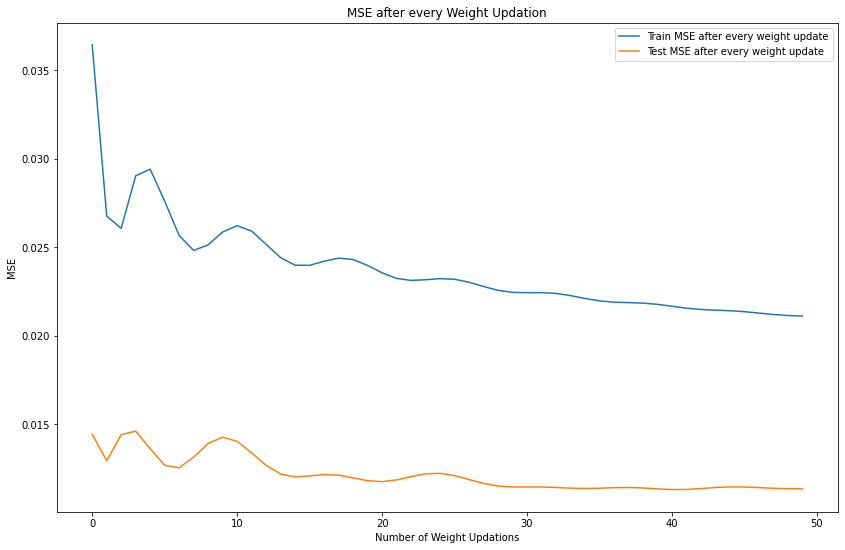

In [83]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_rnn)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_rnn)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

#### 1B: TRAINING 45 BPTT models and making the predictions - using Sequence Length 10 for more lag inputs

In [84]:
input_size = 11
hidden_dim = 10
n_layers = 1
seq_len = 10

mse_train2 = []
mse_test2 = []
Y_pred_train_lst2 = []
Y_pred_test_lst2 = []

for i in range(1,int(len(stores_dict)/2)+1):
    train_loader = stores_dict2["store_{}_train".format(i)]
    test_loader = stores_dict2["store_{}_test".format(i)]

    model_rnn = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt
    model_rnn = model_rnn.float()
    
    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    
    optimizer = optim.Adam(model_rnn.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate
    
    epochs = 30


    ### Training on the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader:    
               # Training pass
            output = model_rnn(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
            
    with torch.no_grad():
        for inputs_train,targets_train in train_loader:
            Y_pred_train = model_rnn(inputs_train.float())  ### Week level Predicted Sales for each store's train data
            mse_train2.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
            
    with torch.no_grad():    
        for inputs_test,targets_test in test_loader:
            Y_pred_test = model_rnn(inputs_test.float())  ### Weekly Predicted Sales for each store's test data
            mse_test2.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data
    
    ### Append Weekly Predictions of each store into a list
    Y_pred_train_lst2.append([el[0] for el in Y_pred_train.tolist()])
    Y_pred_test_lst2.append([el[0] for el in Y_pred_test.tolist()])

#### Average Train & Test MSE across all 45 stores

In [85]:
print(float(sum(mse_test2)/len(mse_test2)))
print(float(sum(mse_train2)/len(mse_train2)))

0.022855384275317192
0.02607257291674614


#### Plotting Actual Vs Predicted Sales using Approach 1B, on Train & Test Data of Stores 20 & 4

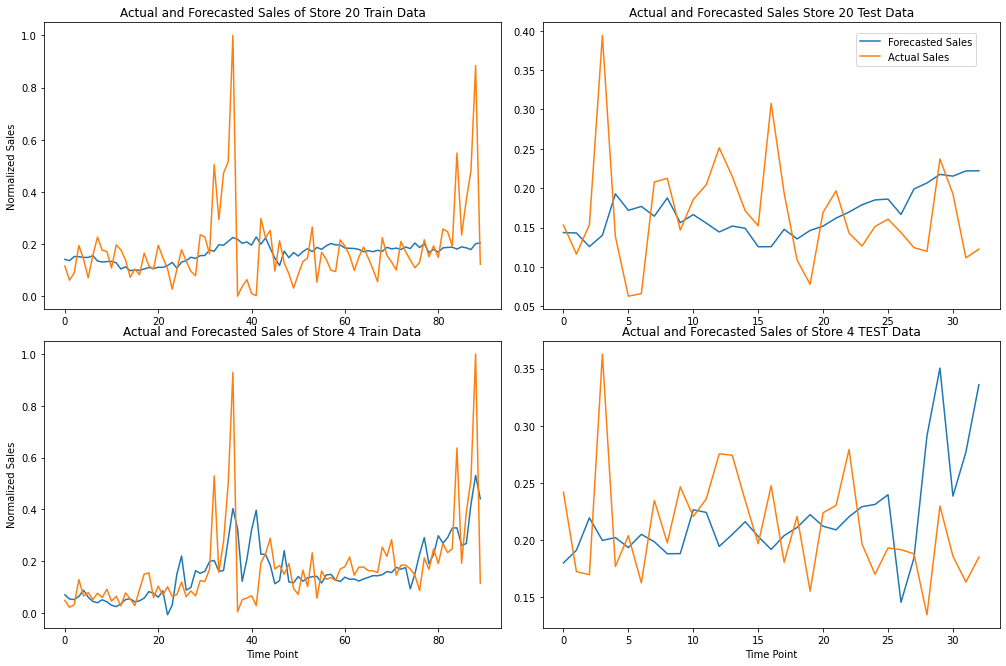

In [86]:
time_point_train = [el for el in range(0,90)]
time_point_test = [el for el in range(0,33)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst2[19])
axs[0, 0].plot(time_point_train, list(stores_dict_tgt2["store_20_train"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst2[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict_tgt2["store_20_test"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst2[3])
axs[1, 0].plot(time_point_train, list(stores_dict_tgt2["store_4_train"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst2[3])
axs[1, 1].plot(time_point_test, list(stores_dict_tgt2["store_4_test"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

## APPROACH EXPERIMENT 2: Train One single BPTT Model
In the approach, the time series aspect (moving window technique) along with the characteristics of a store ('store type', 'store size'), other external characteristics ('Temperature','Fuel_Price','CPI','Unemployment','IsHoliday') along with week of the year ('week_nbr_periodic') columns are used as input attributes to make the predictions. This is implemented by training a single BPTT model on the entire store level aggregated dataset which is common for all the stores. The store level attributes can also be used for training the model with this approach, as we are training a single model across all the stores using a unified dataset.

In [87]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


#### Creating a single unified Store Level weekly sales dataset with 10 lagged moving window for every store
Sliding window sequences are created seperately for every store as the lags for every store have to be provided in isolation. Because we don't want to feed in the past values of one store as inputs to another store

In [88]:
%%capture
stores_dict_ips = {}
stores_dict_tgt3 = {}
stores_dict_df3 = {}
stores_dict3 = {}   ### Creating a dictionary containing the 45 stores

store_train_x = store_lvl_df.iloc[:4433,].drop(columns=['Date','Store','week_nbr'])
store_train_y = store_lvl_df.iloc[:4433,]['Weekly_Sales_sum'].to_frame()
store_test_x = store_lvl_df.iloc[4433:,].drop(columns=['Date','Store','week_nbr'])
store_test_y = store_lvl_df.iloc[4433:,]['Weekly_Sales_sum'].to_frame()

#### Applying Scaler on entire Store Level Aggregated dataset
scaler = MinMaxScaler()
scaler = scaler.fit(store_train_x)
train_arr_x = scaler.transform(store_train_x)
test_arr_x = scaler.transform(store_test_x)
    
scaler = scaler.fit(store_train_y)
train_arr_y = scaler.transform(store_train_y)
test_arr_y = scaler.transform(store_test_y)

#### Creating Sliding Windows for Store 1
x_train, y_train = data_prep(train_arr_x[0:143],train_arr_y[0:143],10)
x_test, y_test = data_prep(test_arr_x[0:143],test_arr_y[0:143],10)

### Creating Sliding windows for other stores 2 to 45 and concatenating them into a single numpy array
for i in range(143,len(train_arr_x),143):   
    ### Calling Data Prep Function to create multivariate sequences (10 lag moving window) Processed
    x_train_store, y_train_store = data_prep(train_arr_x[i:i+143],train_arr_y[i:i+143],10)
    x_train = np.concatenate((x_train, x_train_store), axis=0)
    y_train = np.concatenate((y_train, y_train_store), axis=0)
    
for j in range(143,len(test_arr_x),143):  
    x_test_store, y_test_store = data_prep(test_arr_x[j:j+143],test_arr_y[j:j+143],10)
    x_test = np.concatenate((x_test, x_test_store), axis=0)
    y_test = np.concatenate((y_test, y_test_store), axis=0)
    
### Creating Train & Test Loader Objects
train_target3 = torch.tensor(y_train.astype(np.float32))
train3 = torch.tensor(x_train.astype(np.float32)) 
train_tensor3 = torch.utils.data.TensorDataset(train3, train_target3) 
train_loader3 = torch.utils.data.DataLoader(dataset = train_tensor3, batch_size = len(train3), shuffle = False)
    
test_target3 = torch.tensor(y_test.astype(np.float32))
test3 = torch.tensor(x_test.astype(np.float32)) 
test_tensor3 = torch.utils.data.TensorDataset(test3, test_target3) 
test_loader3 = torch.utils.data.DataLoader(dataset = test_tensor3, batch_size = len(test3),shuffle = False)  

In [89]:
print(len(y_train))
print(y_train.shape)
print(len(x_train))
print(x_train.shape)

print(len(y_test))
print(y_test.shape)
print(len(x_test))
print(x_test.shape)

4123
(4123, 1)
4123
(4123, 10, 11)
1862
(1862, 1)
1862
(1862, 10, 11)


*Here again, the train object has 4123 rows per batch, 11 predictor attributes and sequence of length 10 per attribute (10 past values)*

In [90]:
print(train3.shape)
print(train_target3.shape)
print(test3.shape)
print(test_target3.shape)

torch.Size([4123, 10, 11])
torch.Size([4123, 1])
torch.Size([1862, 10, 11])
torch.Size([1862, 1])


In [93]:
input_size = 11
hidden_dim = 10
n_layers = 1
seq_len = 10

mse_train3 = []
mse_test3 = []
Y_pred_train_lst3 = []
Y_pred_test_lst3 = []

model_rnn = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_rnn
model_rnn = model_rnn.float()

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_rnn.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 80

train_MSE_aft_weight_upd_rnn3 = []
test_MSE_aft_weight_upd_rnn3 = []

### Training on the dataset.
for e in range(epochs):
    for inputs,targets in train_loader3:    
           # Training pass
        output = model_rnn(inputs.float())   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_rnn3.append(loss.item())        
        test_MSE_aft_weight_upd_rnn3.append(test_mse_rnn(model_rnn,test_loader3))
        
with torch.no_grad():
    for inputs_train,targets_train in train_loader3:
        Y_pred_train = model_rnn(inputs_train.float())  ### Week level Predicted Sales for each store's train data
        mse_train3.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
        
with torch.no_grad():    
    for inputs_test,targets_test in test_loader3:
        Y_pred_test = model_rnn(inputs_test.float())  ### Weekly Predicted Sales for each store's test data
        mse_test3.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data

### Append Weekly Predictions into a list
Y_pred_train_lst3.append([el[0] for el in Y_pred_train.tolist()])
Y_pred_test_lst3.append([el[0] for el in Y_pred_test.tolist()])

#### 80 Epochs are sufficient for the model to converge

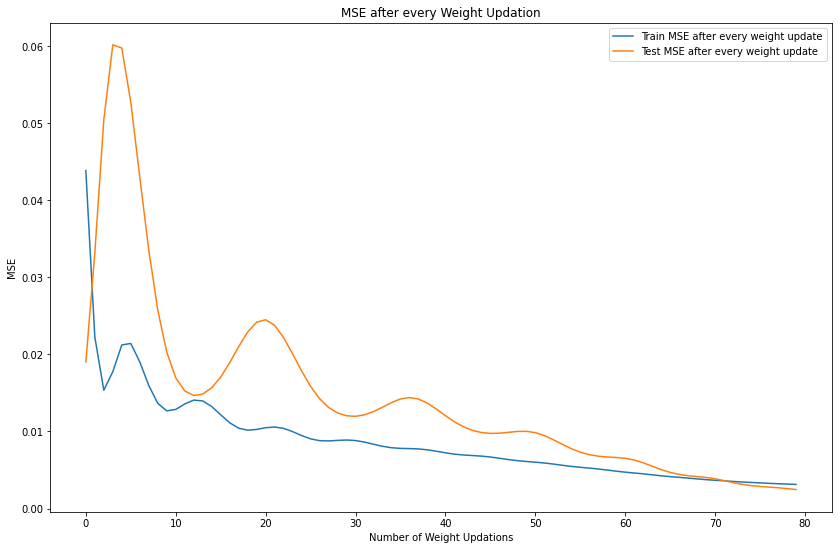

In [94]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_rnn3)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_rnn3)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

*TRAIN & TEST MSE*

In [ ]:
print(mse_train3,mse_test3)

[tensor(0.0083)] [tensor(0.0102)]


#### Plotting Actual Vs Predicted Sales using Approach 2, on Stores 1, 2, 32 & 33

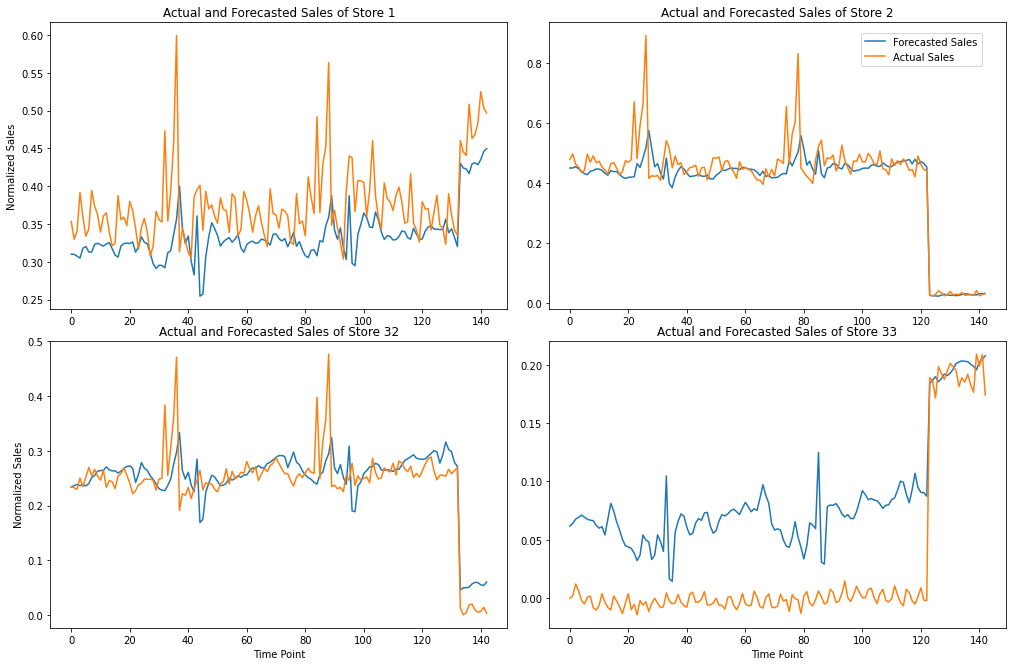

In [95]:
time_point_train = [el for el in range(0,143)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 1 
axs[0, 0].plot(time_point_train, Y_pred_train_lst3[0][:143])
axs[0, 0].plot(time_point_train, [el[0] for el in y_train][:143])
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 1')
axs[0, 0].set_ylabel('Normalized Sales')


### STORE 2 
axs[0, 1].plot(time_point_train, Y_pred_train_lst3[0][143:286])
axs[0, 1].plot(time_point_train, [el[0] for el in y_train][143:286])
axs[0, 1].set_title('Actual and Forecasted Sales of Store 2')


### STORE 32
axs[1, 0].plot(time_point_train, Y_pred_test_lst3[0][0:143])
axs[1, 0].plot(time_point_train, [el[0] for el in y_test][0:143])
axs[1, 0].set_title('Actual and Forecasted Sales of Store 32')
axs[1, 0].set_ylabel('Normalized Sales')
axs[1, 0].set_xlabel('Time Point')

### STORE 33
axs[1, 1].plot(time_point_train, Y_pred_test_lst3[0][143:286])
axs[1, 1].plot(time_point_train, [el[0] for el in y_test][143:286])
axs[1, 1].set_title('Actual and Forecasted Sales of Store 33')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### Conclusion: We can observe that out of the 3 BPTT models built using approach 1A, 1B & 2, approach 2 is having the best performance as it is able to do a better job with detecting the peaks and dips. Moreover, Approach 2 also has a lower Train & Test MSE.

#### COMPARISON

In [96]:
Comparison_dict = {}
Comparison_dict['BPTT Methods'] = ['45 models:Moving Window Seq 5','45 models:Moving Window Seq 10','1 model Seq 10']
Comparison_dict['Train_MSE'] = [float(sum(mse_train)/len(mse_train)),float(sum(mse_train2)/len(mse_train2)),float(mse_train3[0])]
Comparison_dict['Test_MSE'] = [float(sum(mse_test)/len(mse_test)),float(sum(mse_test2)/len(mse_test2)),float(mse_test3[0])]
pd.DataFrame.from_dict(Comparison_dict)

,BPTT Methods,Train_MSE,Test_MSE
0,45 models:Moving Window Seq 5,0.017092,0.022841
1,45 models:Moving Window Seq 10,0.026073,0.022855
2,1 model Seq 10,0.003083,0.002462
